In [1]:
# Predict whether people have diabetes when their characteristics are specified.
# It is desired to develop a machine learning model that can model data analysis and feature engineering steps required
# before development you are expected to do.
import numpy as np
import pandas as pd
import  seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate

In [2]:
df = pd.read_csv("diabetes.csv")

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.shape

(768, 9)

In [5]:
df.info

<bound method DataFrame.info of      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   5

In [6]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [7]:
# Capture numeric and categorical variables.
cat_cols = [col for col in df.columns if str(df[col].dtypes) in ["category", "object", "bool"]]
num_but_cat = [col for col in df.columns if df[col].nunique() < 10 and df[col].dtypes in ["int64", "float"]]
cat_but_car = [col for col in df.columns if df[col].nunique() > 20 and str(df[col].dtypes) in ["category", "object", "bool"]]
cat_cols = cat_cols + num_but_cat
cat_cols = [col for col in cat_cols if col not in cat_but_car]
num_cols = [col for col in df.columns if df[col].dtypes in ["int64", "float"]]
num_cols = [col for col in df.columns if col not in cat_cols]
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"cat_cols: {len(cat_cols)}")
print(f"num_cols: {len(num_cols)}")
print(f"cat_but_car: {len(cat_but_car)}")
print(f"num_but_cat: {len(num_but_cat)}")

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [8]:
df[cat_cols].nunique()

Outcome    2
dtype: int64

In [9]:
df[num_cols].nunique()

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
dtype: int64

   Outcome      Ratio
0      500  65.104167
1      268  34.895833


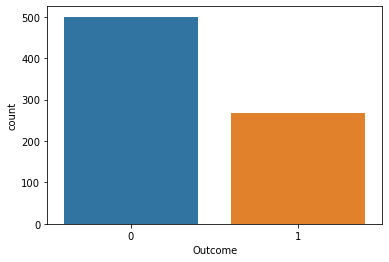

In [10]:
print(pd.DataFrame({"Outcome": df["Outcome"].value_counts(),"Ratio": 100 * df["Outcome"].value_counts() / len(df)}))
sns.countplot(x=df["Outcome"], data=df)
plt.show(block=True)

In [11]:
# Perform target variable analysis. (The mean of the target variable according to the categorical variables, mean of numerical variables)
# There is no need for target analysis for categorical variables, as Outcome is the only categorical variable.

In [12]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(pd.DataFrame(dataframe.groupby(target).agg({numerical_col:"mean"})))

for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672
            Glucose
Outcome            
0        109.980000
1        141.257463
         BloodPressure
Outcome               
0            68.184000
1            70.824627
         SkinThickness
Outcome               
0            19.664000
1            22.164179
            Insulin
Outcome            
0         68.792000
1        100.335821
               BMI
Outcome           
0        30.304200
1        35.142537
         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500
               Age
Outcome           
0        31.190000
1        37.067164


In [13]:
# Analysis Of Numerical Variables
quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
df[num_cols].describe(quantiles).T

,count,mean,std,min,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
Pregnancies,768.0,3.845052,3.369578,0.000,0.00000,0.000,1.0000,1.000,2.0000,3.0000,4.0000,5.0000,7.000,9.0000,10.00000,13.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,79.00000,85.000,95.0000,102.000,109.0000,117.0000,125.0000,134.0000,147.000,167.0000,181.00000,196.00000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,38.70000,54.000,60.0000,64.000,68.0000,72.0000,74.0000,78.0000,82.000,88.0000,90.00000,106.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,0.000,0.0000,8.200,18.0000,23.0000,27.0000,31.0000,35.000,40.0000,44.00000,51.33000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,0.000,0.0000,0.000,0.0000,30.5000,72.2000,106.0000,150.000,210.0000,293.00000,519.90000,846.00
BMI,768.0,31.992578,7.884160,0.000,21.80000,23.600,25.9000,28.200,30.1000,32.0000,33.7000,35.4900,37.800,41.5000,44.39500,50.75900,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.14035,0.165,0.2194,0.259,0.3028,0.3725,0.4542,0.5637,0.687,0.8786,1.13285,1.69833,2.42
Age,768.0,33.240885,11.760232,21.000,21.00000,22.000,23.0000,25.000,27.0000,29.0000,33.0000,38.0000,42.600,51.0000,58.00000,67.00000,81.00


count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64


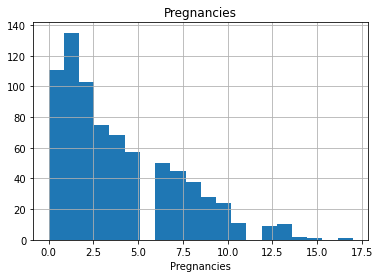

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64


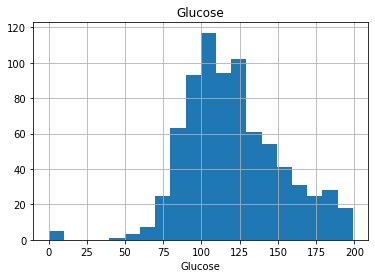

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64


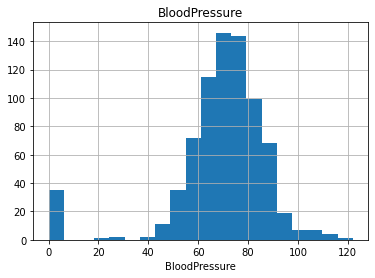

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        8.200000
40%       18.000000
50%       23.000000
60%       27.000000
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SkinThickness, dtype: float64


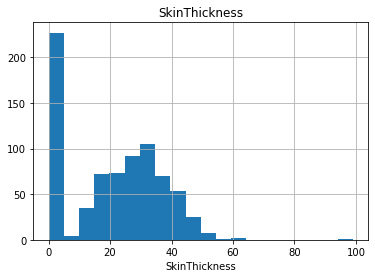

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: Insulin, dtype: float64


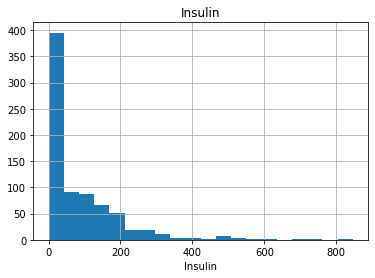

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


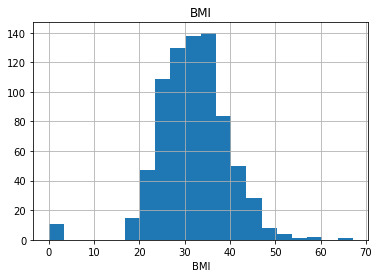

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


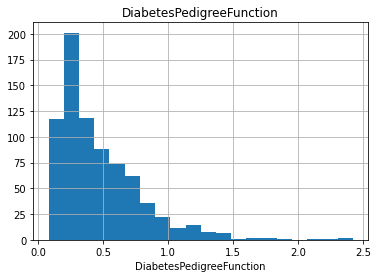

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64


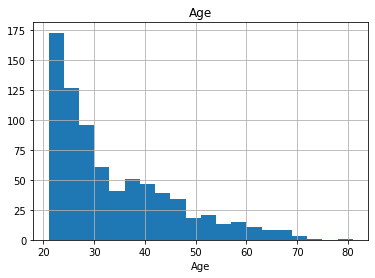

In [14]:
# Analysis Of Numerical Variables PLOT
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()
        
        
for col in num_cols:
    num_summary(df, col, plot=True)

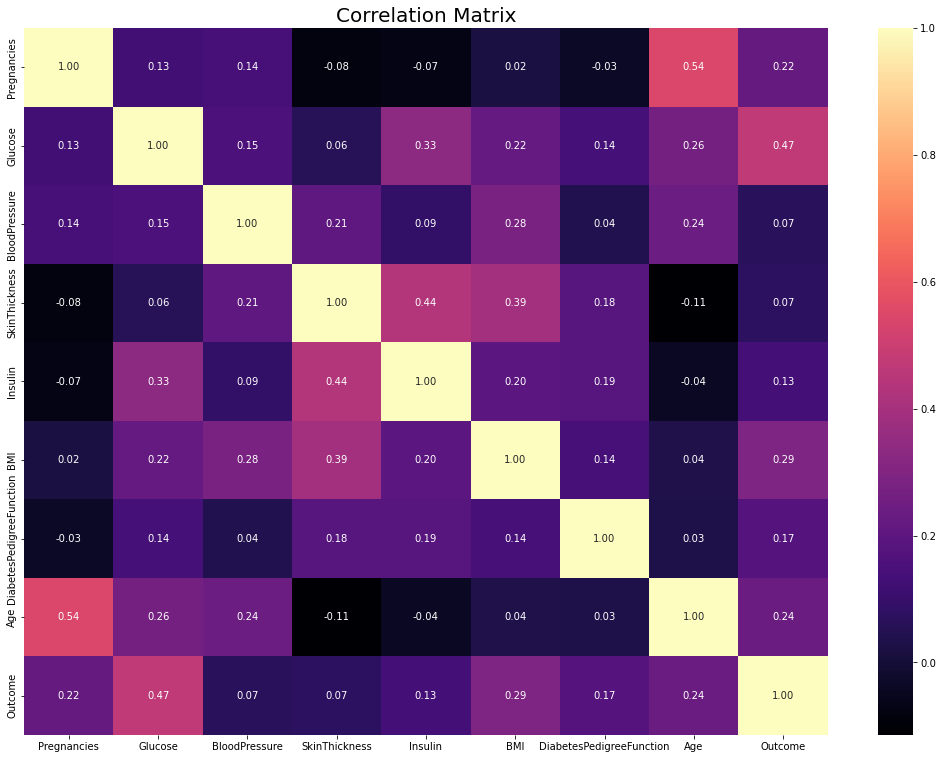

In [15]:
df.corr()

# Correlation Matrix

f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [16]:
# Finding Missing Values
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]
zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [17]:
# Assigning Missing Values to NaN
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

In [18]:
# Missing Values
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [19]:
# Filling Missing Values with Median
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()

df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [20]:
# Outlier Analysis
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

for col in df.columns:
    low, up = outlier_thresholds(df, col)
    print("Column: ",col)
    print("Low: ",low)
    print("Up: ",up,"\n")

Column:  Pregnancies
Low:  -15.0
Up:  25.0 

Column:  Glucose
Low:  -71.5
Up:  332.5 

Column:  BloodPressure
Low:  -5.0
Up:  147.0 

Column:  SkinThickness
Low:  -30.124999999999993
Up:  88.475 

Column:  Insulin
Low:  -314.5
Up:  657.5 

Column:  BMI
Low:  -11.004999999999995
Up:  77.63499999999999 

Column:  DiabetesPedigreeFunction
Low:  -1.3483999999999996
Up:  2.621599999999999 

Column:  Age
Low:  -34.5
Up:  113.5 

Column:  Outcome
Low:  -1.5
Up:  2.5 



In [21]:
# Is there an Outlier or not?
def check_outlier(dataframe, col_name):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] < low) | (dataframe[col_name] > up)].any(axis=None):
        return True
    else:
        return False
print("Columns with Outlier\n")
for col in df.columns:
    if check_outlier(df, col):
        print(col)

Columns with Outlier

SkinThickness
Insulin


In [22]:
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
for col in df.columns:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)
        
for col in df.columns:
    print(col, ":", check_outlier(df, col),"\n")
    

Pregnancies : False 

Glucose : False 

BloodPressure : False 

SkinThickness : False 

Insulin : False 

BMI : False 

DiabetesPedigreeFunction : False 

Age : False 

Outcome : False 



In [23]:
# Creating new variables
# Age Periods Of Human Life
df.loc[(df["Age"] >= 21) & (df["Age"] < 44), "Age_Group"] = "Young Age"
df.loc[(df["Age"] >= 44) & (df["Age"] < 60), "Age_Group"] = "Middle Age"
df.loc[(df["Age"] >= 60) & (df["Age"] < 75), "Age_Group"] = "Elderly Age"
df.loc[(df["Age"] >= 75) & (df["Age"] < 90), "Age_Group"] = "Senile  Age"
df.loc[(df["Age"] >= 90), "Age_Group"] = "Long-Rivers"
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_Group
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,Middle Age
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,Young Age
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,Young Age
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Young Age
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Young Age


In [24]:
# BMI Categories
df.loc[(df["BMI"] < 18.6), "BMI_Categories"] = "Underweight"
df.loc[(df["BMI"] >= 18.6) & (df["BMI"] < 25), "BMI_Categories"] = "Normal weight"
df.loc[(df["BMI"] >= 25) & (df["BMI"] < 30), "BMI_Categories"] = "Overweight"
df.loc[(df["BMI"] >= 30), "BMI_Categories"] = "Obesity"
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_Group,BMI_Categories
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,Middle Age,Obesity
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,Young Age,Overweight
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,Young Age,Normal weight
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Young Age,Overweight
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Young Age,Obesity


In [25]:
# Insulin Level
df.loc[(df["Insulin"] >= 16) & (df["Insulin"] <= 166), "Insulin_Level"] = "Normal"
df.loc[(df["Insulin"] > 166), "Insulin_Level"] = "High"
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_Group,BMI_Categories,Insulin_Level
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,Middle Age,Obesity,Normal
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,Young Age,Overweight,Normal
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,Young Age,Normal weight,Normal
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Young Age,Overweight,Normal
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Young Age,Obesity,High


In [26]:
# Blood Pressure
df.loc[(df["BloodPressure"] < 80), "Blood_Pressure"] = "Normal"
df.loc[(df["BloodPressure"] >= 80) & (df["BloodPressure"] <= 89), "Blood_Pressure"] = "High BP Stage 1"
df.loc[(df["BloodPressure"] > 89) & (df["BloodPressure"] <= 120), "Blood_Pressure"] = "High BP Stage 2"
df.loc[(df["BloodPressure"] > 120), "Blood_Pressure"] = "Crisis High BP"
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_Group,BMI_Categories,Insulin_Level,Blood_Pressure
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,Middle Age,Obesity,Normal,Normal
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,Young Age,Overweight,Normal,Normal
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,Young Age,Normal weight,Normal,Normal
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Young Age,Overweight,Normal,Normal
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Young Age,Obesity,High,Normal


In [27]:
# Recategorizing
cat_cols = [col for col in df.columns if str(df[col].dtypes) in ["category", "object", "bool"]]
num_but_cat = [col for col in df.columns if df[col].nunique() < 10 and df[col].dtypes in ["int64", "float"]]
cat_but_car = [col for col in df.columns if df[col].nunique() > 20 and str(df[col].dtypes) in ["category", "object", "bool"]]
cat_cols = cat_cols + num_but_cat
cat_cols = [col for col in cat_cols if col not in cat_but_car]
num_cols = [col for col in df.columns if df[col].dtypes in ["int64", "float"]]
num_cols = [col for col in df.columns if col not in cat_cols]
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"cat_cols: {len(cat_cols)}")
print(f"num_cols: {len(num_cols)}")
print(f"cat_but_car: {len(cat_but_car)}")
print(f"num_but_cat: {len(num_but_cat)}")

Observations: 768
Variables: 13
cat_cols: 5
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [28]:
# Label Encoding
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]
for col in binary_cols:
    df = label_encoder(df, col)
binary_cols

['Outcome', 'Insulin_Level']

In [29]:
# One-Hat Encoding
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
ohe_cols

['Age_Group', 'BMI_Categories', 'Insulin_Level', 'Blood_Pressure']

In [30]:
one_hot_encoder(df, ohe_cols).head()
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [31]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Age_Group_Middle Age,Age_Group_Senile Age,Age_Group_Young Age,BMI_Categories_Obesity,BMI_Categories_Overweight,BMI_Categories_Underweight,Insulin_Level_1,Insulin_Level_2,Blood_Pressure_High BP Stage 1,Blood_Pressure_High BP Stage 2,Blood_Pressure_Normal,Outcome_1
0,0.639947,0.866045,-0.031990,0.680052,-0.182749,0.166619,0.468492,1.425995,1,0,0,1,0,0,1,0,0,0,1,1
1,-0.844885,-1.205066,-0.528319,-0.010867,-0.182749,-0.852200,-0.365061,-0.190672,0,0,1,0,1,0,1,0,0,0,1,0
2,1.233880,2.016662,-0.693761,-0.010867,-0.182749,-1.332500,0.604397,-0.105584,0,0,1,0,0,0,1,0,0,0,1,1
3,-0.844885,-1.073567,-0.528319,-0.701786,-0.553400,-0.633881,-0.920763,-1.041549,0,0,1,0,1,0,1,0,0,0,1,0
4,-1.141852,0.504422,-2.679076,0.680052,0.331380,1.549303,5.484909,-0.020496,0,0,1,1,0,0,0,0,0,0,1,1


In [32]:
df.shape

(768, 20)

In [33]:
y = df["Outcome_1"]
x = df.drop("Outcome_1", axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30)
rf_model = RandomForestClassifier(random_state=46).fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

In [34]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred, y_test), 3)}")
print(f"Precision: {round(precision_score(y_pred, y_test), 2)}")
print(f"F1: {round(f1_score(y_pred, y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

Accuracy: 0.81
Recall: 0.739
Precision: 0.65
F1: 0.69
Auc: 0.79


       Value                         Feature
1   0.234123                         Glucose
5   0.138845                             BMI
6   0.112004        DiabetesPedigreeFunction
7   0.108948                             Age
0   0.079866                     Pregnancies
4   0.079234                         Insulin
3   0.074506                   SkinThickness
2   0.073614                   BloodPressure
11  0.029438          BMI_Categories_Obesity
14  0.012402                 Insulin_Level_1
12  0.010922       BMI_Categories_Overweight
16  0.010365  Blood_Pressure_High BP Stage 1
18  0.010009           Blood_Pressure_Normal
10  0.009778             Age_Group_Young Age
8   0.009532            Age_Group_Middle Age
17  0.006128  Blood_Pressure_High BP Stage 2
15  0.000166                 Insulin_Level_2
9   0.000082           Age_Group_Senile  Age
13  0.000039      BMI_Categories_Underweight


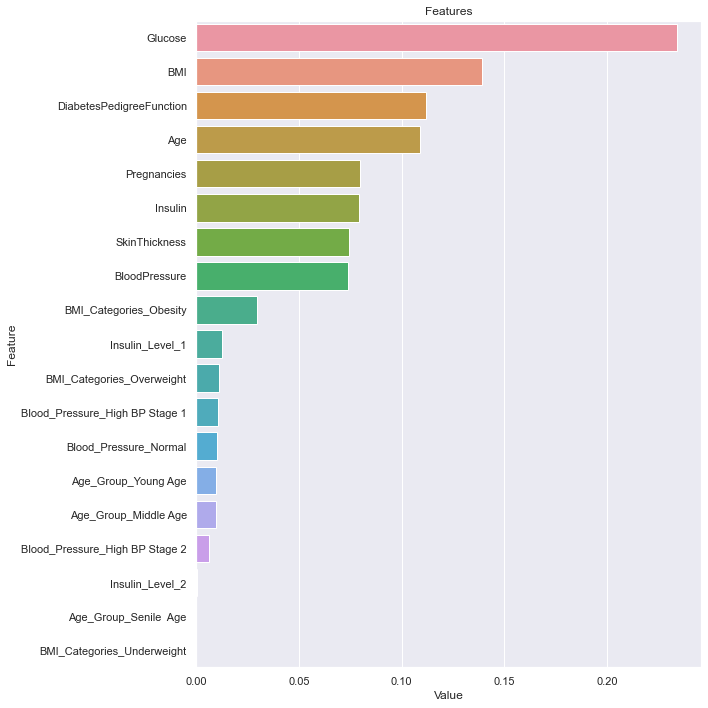

In [35]:
# FEATURE IMPORTANCE
def plot_importance(model, features, num=len(x), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value", ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, x)

In [36]:
# knn
knn_model = KNeighborsClassifier().fit(x, y)

In [37]:
random_user = x.sample(1, random_state=45)
random_user

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Age_Group_Middle Age,Age_Group_Senile Age,Age_Group_Young Age,BMI_Categories_Obesity,BMI_Categories_Overweight,BMI_Categories_Underweight,Insulin_Level_1,Insulin_Level_2,Blood_Pressure_High BP Stage 1,Blood_Pressure_High BP Stage 2,Blood_Pressure_Normal
195,0.342981,1.194792,0.960667,1.370971,0.833552,1.010784,-0.232176,-0.360847,0,0,1,1,0,0,0,0,1,0,0


In [38]:
knn_model.predict(random_user)

array([0], dtype=uint8)

In [39]:
y_pred = knn_model.predict(x)  
y_prob = knn_model.predict_proba(x)[:, 1]  #1 sınıfına ait olma olasılıkları
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       500
           1       0.78      0.69      0.74       268

    accuracy                           0.83       768
   macro avg       0.81      0.80      0.80       768
weighted avg       0.82      0.83      0.82       768



In [40]:
roc_auc_score(y, y_prob)

0.9045223880597015

In [41]:
cv_results = cross_validate(knn_model, x, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()

0.7278838808250574

In [42]:
cv_results['test_f1'].mean()

0.5997588736086115

In [43]:
cv_results['test_roc_auc'].mean()

0.7946841369671558

In [44]:
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [45]:
knn_params = {"n_neighbors": range(2, 50)}
knn_gs_best = GridSearchCV(knn_model,
                           knn_params,
                           cv=5,
                           n_jobs=-1,
                           verbose=1).fit(x, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [46]:
knn_gs_best.best_params_

{'n_neighbors': 25}

In [47]:
knn_final = knn_model.set_params(**knn_gs_best.best_params_).fit(x, y)

In [48]:
cv_results = cross_validate(knn_final,
                            x,
                            y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

In [49]:
cv_results['test_accuracy'].mean()

0.7656735421441303

In [50]:
cv_results['test_f1'].mean()

0.6202980715169943

In [51]:
cv_results['test_roc_auc'].mean()

0.8336512928022362

In [52]:
random_user = x.sample(1)
knn_final.predict(random_user)

array([0], dtype=uint8)